In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [2]:
import os
import math
import random
import numpy as np
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.6/8062.4 GB disk)


In [3]:
# Create dataset directories
os.makedirs('datasets/train/images', exist_ok=True)
os.makedirs('datasets/valid/images', exist_ok=True)
os.makedirs('datasets/test/images', exist_ok=True)
os.makedirs('datasets/train/labels', exist_ok=True)
os.makedirs('datasets/valid/labels', exist_ok=True)
os.makedirs('datasets/test/labels', exist_ok=True)

# Paths for train, valid, and test sets
train_path = 'datasets/train/'
valid_path = 'datasets/valid/'
test_path = 'datasets/test/'

# Path to the dataset
# Replace with your actual path to the dice dataset
DATASET_PATH = '/kaggle/input/d6-dice/d6-dice'

# Get all annotation files
ano_paths = []
for dirname, _, filenames in os.walk(os.path.join(DATASET_PATH, 'Annotations')):
    for filename in filenames:
        if filename.endswith('.txt'):
            ano_paths.append(os.path.join(dirname, filename))

# Filter out annotations that don't have corresponding image files
valid_ano_paths = []
for ano_path in ano_paths:
    base_name = os.path.basename(ano_path)[0:-4]
    img_path = os.path.join(DATASET_PATH, 'Images', base_name + '.jpg')
    if os.path.exists(img_path):
        valid_ano_paths.append(ano_path)
    else:
        print(f"Skipping annotation without image: {base_name}")

n = len(valid_ano_paths)
print(f"Total number of valid annotations: {n}")
N = list(range(n))
random.shuffle(N)

# Split data according to specified ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

train_size = int(train_ratio * n)
valid_size = int(valid_ratio * n)

train_i = N[:train_size]
valid_i = N[train_size:train_size+valid_size]
test_i = N[train_size+valid_size:]

print(f"Train set size: {len(train_i)}")
print(f"Validation set size: {len(valid_i)}")
print(f"Test set size: {len(test_i)}")

Skipping annotation without image: classes
Total number of valid annotations: 250
Train set size: 175
Validation set size: 50
Test set size: 25


In [4]:
# Copy files to respective directories
def copy_files(indices, dest_path, prefix='Moving'):
    """Copy image and annotation files to destination directory."""
    success_count = 0
    for i in tqdm(indices, desc=prefix):
        ano_path = valid_ano_paths[i]
        base_name = os.path.basename(ano_path)[0:-4]
        img_path = os.path.join(DATASET_PATH, 'Images', base_name + '.jpg')
        
        # Skip if image doesn't exist (which shouldn't happen due to filtering)
        if not os.path.exists(img_path):
            print(f"Warning: Image not found: {img_path}")
            continue
            
        # Destination paths for the current file
        dest_img_path = os.path.join(dest_path, 'images', os.path.basename(img_path))
        dest_ano_path = os.path.join(dest_path, 'labels', os.path.basename(ano_path))
        
        try:
            shutil.copy(img_path, dest_img_path)
            shutil.copy(ano_path, dest_ano_path)
            success_count += 1
        except Exception as e:
            print(f"Error copying file {img_path}: {e}")
    
    return success_count

# Copy files to train, validation, and test directories
train_copied = copy_files(train_i, train_path, 'Moving training files')
valid_copied = copy_files(valid_i, valid_path, 'Moving validation files')
test_copied = copy_files(test_i, test_path, 'Moving test files')

# Print number of files in each directory
print(f"Files in train directory: {len(os.listdir(train_path + 'images'))}")
print(f"Files in validation directory: {len(os.listdir(valid_path + 'images'))}")
print(f"Files in test directory: {len(os.listdir(test_path + 'images'))}")
print(f"Successfully copied: {train_copied} training, {valid_copied} validation, {test_copied} test files")


Moving test files: 100%|██████████| 25/25 [00:00<00:00, 94.52it/s]

Files in train directory: 175
Files in validation directory: 50
Files in test directory: 25
Successfully copied: 175 training, 50 validation, 25 test files


In [5]:
# Create YAML configuration for YOLO
data_yaml = dict(
    train='datasets/train/images',
    val='datasets/valid/images',
    test='datasets/test/images',
    nc=6,
    names=['1', '2', '3', '4', '5', '6']
)

# Save YAML configuration
with open('data.yaml', 'w') as outfile:
    yaml.safe_dump(data_yaml, outfile, default_flow_style=False)

print("YAML configuration saved:")
with open('data.yaml', 'r') as f:
    print(f.read())

YAML configuration saved:
names:
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
nc: 6
test: datasets/test/images
train: datasets/train/images
val: datasets/valid/images



In [6]:
# Initialize YOLO model
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 322MB/s] 


In [7]:
# Train the model
results = model.train(
    data='/kaggle/working/data.yaml',
    epochs=20,
    imgsz=640,
    batch=16,
    name='dice_detector'
)

Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=dice_detector, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 43.5MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 165MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1939.4±549.2 MB/s, size: 137.7 KB)


train: Scanning /kaggle/working/datasets/train/labels... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<00:00, 978.28it/s]

train: New cache created: /kaggle/working/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1131.9±733.1 MB/s, size: 168.7 KB)


val: Scanning /kaggle/working/datasets/valid/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 822.15it/s]

val: New cache created: /kaggle/working/datasets/valid/labels.cache


Plotting labels to runs/detect/dice_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/dice_detector
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20        15G      1.615      3.997      1.232        111        640: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]

                   all         50        356      0.333      0.595      0.265      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      15.4G      1.294      2.114      1.058        141        640: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         50        356          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      15.5G      1.265      1.612      1.097        112        640: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         50        356      0.368      0.789      0.538      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      15.4G      1.351      1.659      1.097        104        640: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         50        356      0.102      0.701      0.133      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      14.5G      1.242      1.326      1.051        113        640: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         50        356      0.595      0.722      0.761      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.4G      1.217      1.245      1.071        141        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         50        356      0.395      0.195       0.17      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      12.2G      1.152      1.038      1.029        133        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356       0.64      0.769      0.745        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      12.4G      1.157      1.038      1.024        137        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.725      0.745      0.711       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      12.8G      1.156     0.8674      1.038        175        640: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         50        356      0.316      0.606      0.278      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20        13G       1.14      0.743      1.027        155        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.822      0.824      0.927      0.468


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20        13G      1.198     0.6975      1.143        154        640: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         50        356      0.859      0.842      0.891      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      13.1G      1.171     0.6538      1.092        163        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         50        356      0.945      0.981      0.984      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      12.2G      1.184     0.5719      1.124         99        640: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.935      0.956      0.978      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20        13G      1.182     0.5535      1.117         97        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         50        356       0.83      0.772      0.794      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20        13G       1.16     0.5538      1.121        109        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.929      0.819      0.918      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      13.1G      1.161     0.5484      1.098        121        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.973      0.979      0.988       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      12.8G      1.121     0.5073      1.086        113        640: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         50        356      0.976      0.983      0.991      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20        13G      1.092      0.464      1.066        108        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.973      0.981      0.988      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20        13G      1.092     0.4728      1.066        138        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         50        356      0.975      0.985      0.984      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      13.1G      1.057     0.4351      1.062         86        640: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         50        356      0.979      0.982      0.983      0.623



20 epochs completed in 0.107 hours.
Optimizer stripped from runs/detect/dice_detector/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/dice_detector/weights/best.pt, 136.7MB

Validating runs/detect/dice_detector/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 112 layers, 68,129,346 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


                   all         50        356      0.976      0.982      0.991      0.629
                     1         35         65      0.994          1      0.995      0.651
                     2         33         60      0.967      0.977      0.991      0.604
                     3         36         69      0.958      0.982      0.977      0.644
                     4         31         56      0.977      0.982      0.993      0.622
                     5         34         63      0.961          1      0.993      0.613
                     6         25         43      0.999      0.953      0.994      0.639


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 29.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/dice_detector


In [8]:
# Save the trained model
model.export(format='onnx')
model.save('dice_detector.pt')
print("Model saved successfully")

Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 112 layers, 68,129,346 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs/detect/dice_detector/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (130.4 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 318.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 252.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 313.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.0s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with


image 1/1 /kaggle/working/datasets/test/images/IMG_20191209_095508.jpg: 640x640 1 1, 2 2s, 1 3, 3 4s, 1 6, 34.2ms
Speed: 3.9ms preprocess, 34.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/test/images/IMG_20191208_112246.jpg: 640x640 2 2s, 3 3s, 1 4, 1 5, 4 6s, 34.1ms
Speed: 3.6ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/test/images/IMG_20191208_112933.jpg: 640x640 1 2, 3 3s, 2 4s, 1 5, 2 6s, 33.9ms
Speed: 3.6ms preprocess, 33.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/test/images/IMG_20191209_095958.jpg: 640x640 1 2, 3 3s, 1 5, 34.0ms
Speed: 4.2ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/test/images/IMG_20191209_095854.jpg: 640x640 2 2s, 2 3s, 1 4, 1 5, 1 6, 33.9ms
Speed: 3.7ms preprocess, 33.9ms inference, 1.7

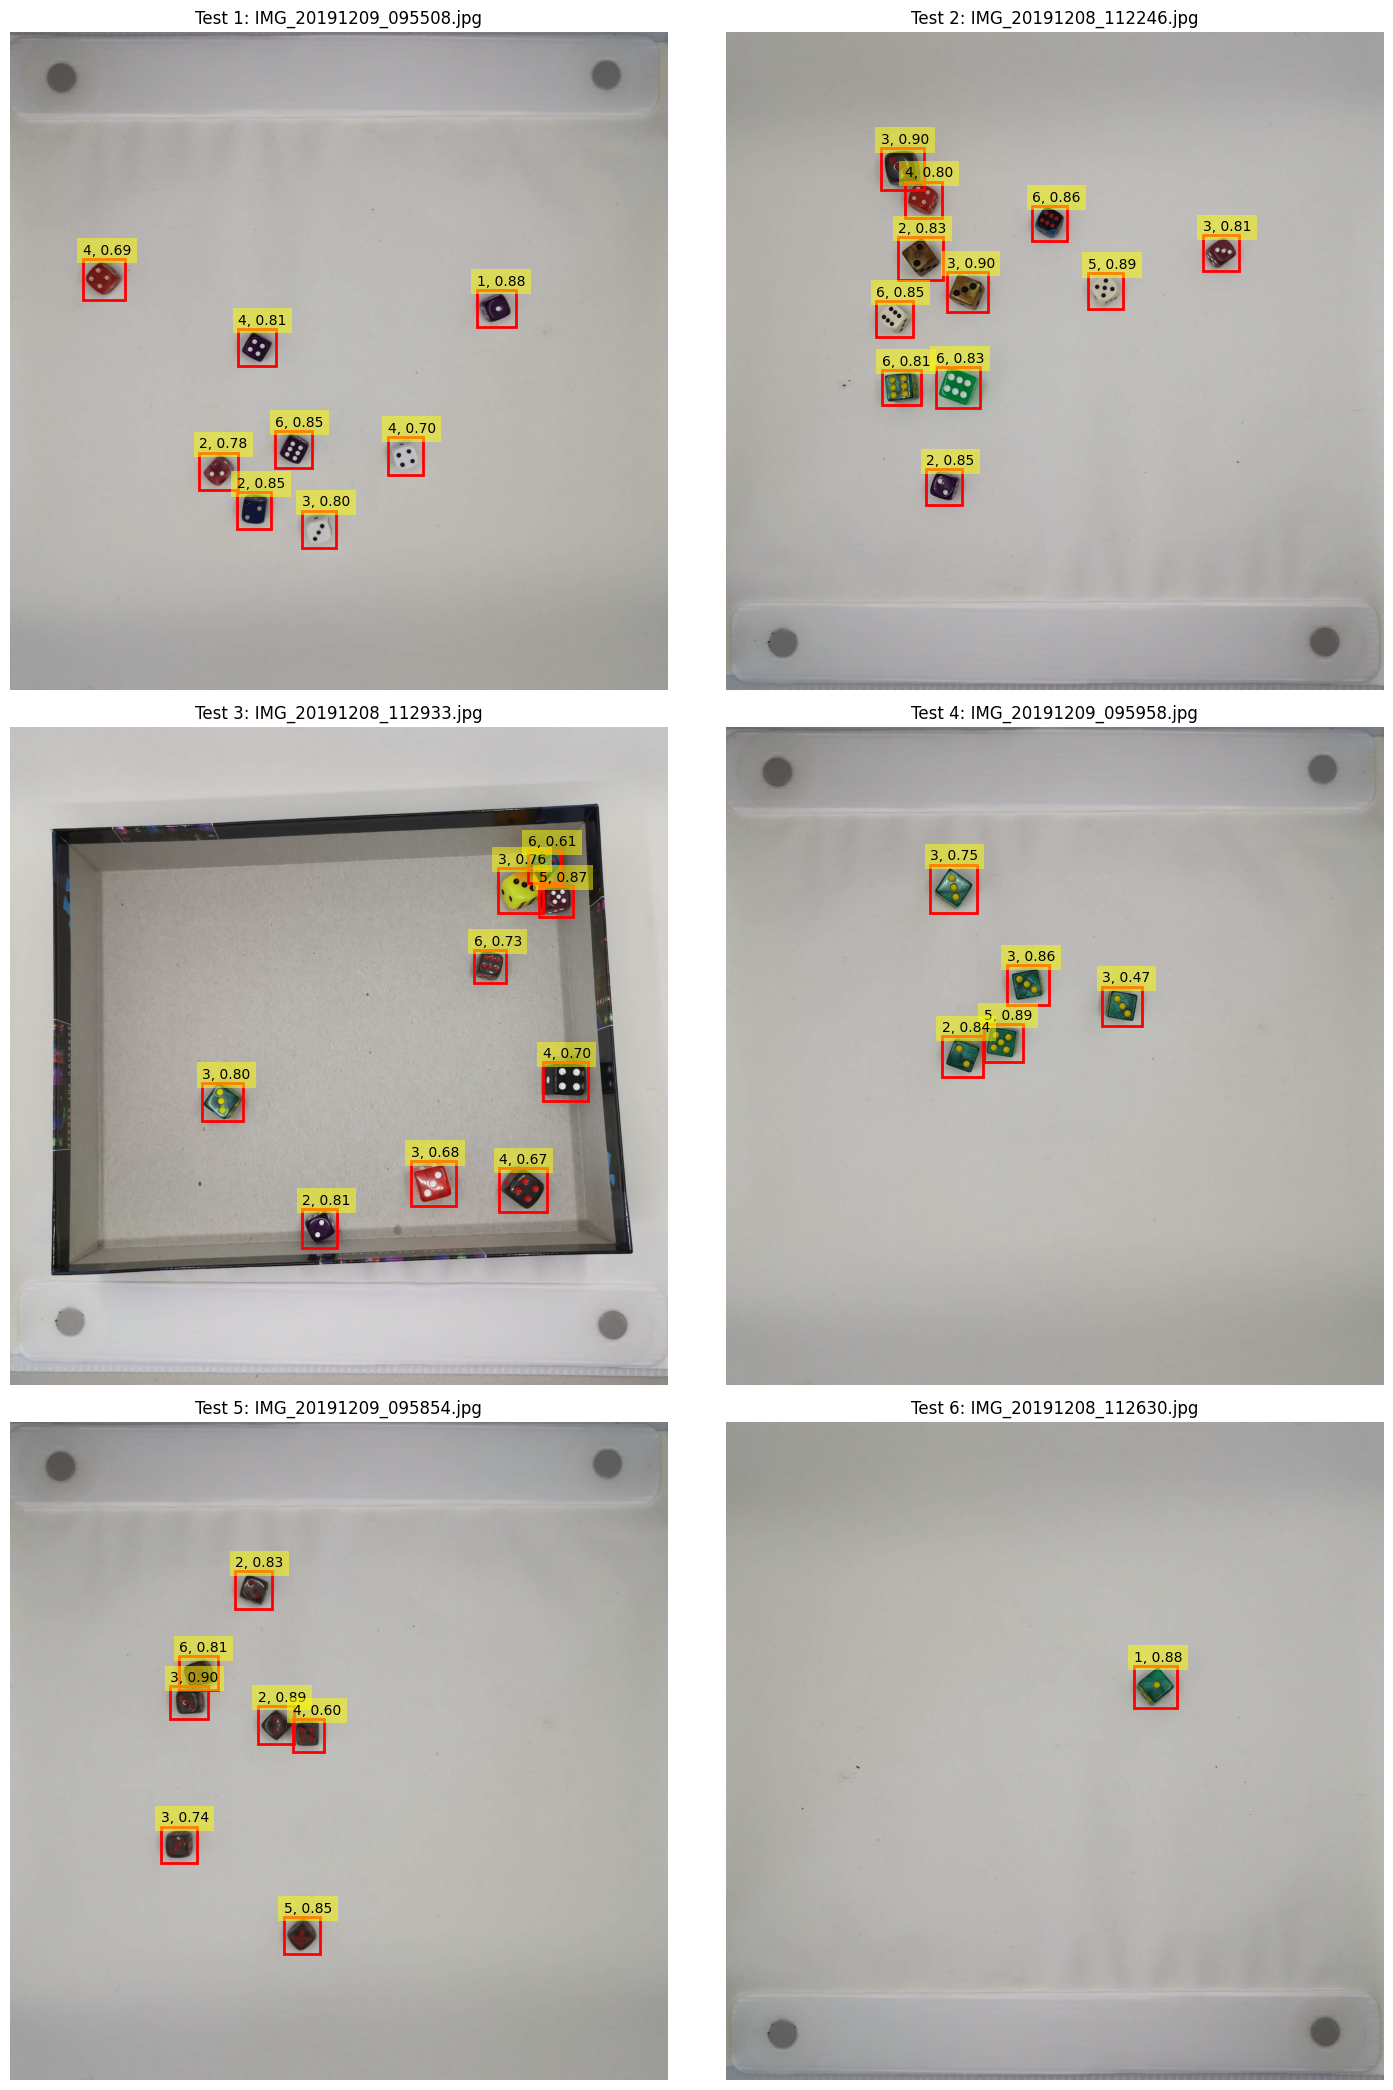

In [9]:
# list your test images directory
test_images = os.listdir(os.path.join(test_path, 'images'))
if test_images:
    # pick up to 6 random images
    n_images = min(6, len(test_images))
    sample_images = random.sample(test_images, n_images)

    cols = 2
    rows = math.ceil(n_images / cols)
    plt.figure(figsize=(15, rows * 7))

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(test_path, 'images', img_file)
        results = model.predict(img_path, conf=0.25)

        # create a subplot
        ax = plt.subplot(rows, cols, i + 1)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Test {i+1}: {img_file}", fontsize=12)
        ax.axis('off')

        # iterate each detection in this image
        for res in results:
            # extract boxes, classes, and confidences
            boxes = res.boxes.xyxy.cpu().numpy()
            classes = res.boxes.cls.cpu().numpy()
            confs = res.boxes.conf.cpu().numpy()

            for box, cls, conf in zip(boxes, classes, confs):
                x1, y1, x2, y2 = box

                # unfilled bounding box
                rect = plt.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    fill=False, edgecolor='red', linewidth=2
                )
                ax.add_patch(rect)

                # label with class name and confidence
                label = model.names[int(cls)] if hasattr(model, 'names') else str(int(cls))
                ax.text(
                    x1, y1 - 5,
                    f"{label}, {conf:.2f}",
                    fontsize=10,
                    verticalalignment='bottom',
                    bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none')
                )

    plt.tight_layout()
    plt.show()

In [10]:
# Evaluate the model on test set
test_results = model.val(data='/kaggle/working/data.yaml', split='test')
print("Test Results:", test_results)

Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1613.5±692.7 MB/s, size: 105.9 KB)


val: Scanning /kaggle/working/datasets/test/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1047.49it/s]

val: New cache created: /kaggle/working/datasets/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


                   all         25        172      0.985      0.993      0.988      0.653
                     1         15         22      0.986          1      0.995      0.708
                     2         21         34      0.956      0.971      0.952      0.613
                     3         18         38          1      0.997      0.995      0.648
                     4         14         25      0.991          1      0.995      0.642
                     5         15         25      0.981          1      0.995      0.691
                     6         17         28          1       0.99      0.995      0.617


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 4.8ms preprocess, 30.8ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/dice_detector2
Test Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2978dc8a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.03